In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Dataset (1 Million Ratings)
# This dataset isn't used to train on low-end devices.
ratings = pd.read_csv("data/ml-1m/ratings.dat", header=None, sep="::", engine="python", encoding="latin-1")

In [8]:
# Training Set (100,000 Ratings)
# This One has less data points than the 1M one. 
# Training will be practical on low-end systems.
training_set = pd.read_csv("data/ml-100k/u1.base", delimiter='\t')
testing_set = pd.read_csv("data/ml-100k/u1.test", delimiter='\t')
training_set = np.array(training_set, dtype='int')
testing_set = np.array(testing_set, dtype='int')

In [10]:
# Total Number of users and movies
max_users = max(max(training_set[:,0]), max(testing_set[:,0]))
max_movies = max(max(training_set[:,1]), max(testing_set[:,1]))

In [21]:
# Convert data into right format
def convert(data):
    new_data = list()
    for id_user in range(1, max_users + 1):
        id_movies = training_set[training_set[:,0] == id_user][:,1]
        id_ratings = training_set[training_set[:,0] == id_user][:,2]
        ratings = np.zeros(max_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [32]:
train_set = convert(training_set)
test_set = convert(testing_set)

In [36]:
# Convert Data to torch tensors
training_set = torch.FloatTensor(train_set)
testing_set = torch.FloatTensor(test_set)

In [62]:
class SAE(nn.Module):
    """
    This Class contains the code for a Stacked AutoEncoder
    It has 2 layers for Encoder and 2 for Decoder with
    Latent Dimesion = 10
    """
    def __init__(this):
        super(SAE, this).__init__()
        # Pssh: Looks like a Domino ;)
        this.fc1 = nn.Linear(max_movies, 20)
        this.fc2 = nn.Linear(20, 10)
        this.fc3 = nn.Linear(10, 20)
        this.fc4 = nn.Linear(20, max_movies)
        this.activation = nn.Sigmoid()
    def forward(this, x):
        x = this.activation(this.fc1(x))
        x = this.activation(this.fc2(x))
        x = this.activation(this.fc3(x))
        x = this.fc4(x)
        return x

In [95]:
# Instatiate the class and make the loss functions
ae = SAE()
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(ae.parameters(), lr=1e-2, weight_decay=0.5)

In [97]:
losses = []

In [105]:
epochs = 100
for epoch in range(1, epochs+1):
    train_loss = 0
    atleast_1_movie = 0.
    for id_user in range(max_users):
        # Adding a Fake dimension to input data (to fool PyTorch thinking it as batch)
        current_input = Variable(training_set[id_user]).unsqueeze(0)
        # Clone the current input as the ground truth (that's why we use AEs!)
        y = current_input.clone()
        
        # Check if a user has rated atleast one movie to save memory
        if torch.sum(y.data > 0) > 0:
            y_hat = ae(current_input)
            # Make sure you don't calculate grad wrt y
            y.require_grad = False
            # Set those values to 0 that don't have any ratings
            y_hat[y == 0] = 0
            # Calculate loss using Loss function
            loss = loss_fn(y_hat, y)
            # Calculate mean using only those movies that actually had a rating
            # Also add a very small number to avoid potential Zero division error
            mean_ = max_movies/float(torch.sum(y_hat.data > 0) + 1e-6)
            # Backpropagate
            loss.backward()
            # Update the training loss
            train_loss += np.sqrt(loss.data * mean_)
            atleast_1_movie += 1
            optimizer.step()
            losses.append((train_loss/atleast_1_movie).data.tolist())
    # Verbose every 10 epochs
    if epoch % 10 == 0:
        print("Epoch: {}, Loss: {}".format(str(epoch), str((train_loss/atleast_1_movie).data.tolist())))

Epoch: 10, Loss: 0.9305812120437622
Epoch: 20, Loss: 0.9281207323074341
Epoch: 30, Loss: 0.9250683188438416
Epoch: 40, Loss: 0.9226075410842896
Epoch: 50, Loss: 0.9208635091781616
Epoch: 60, Loss: 0.9188658595085144
Epoch: 70, Loss: 0.9169273972511292
Epoch: 80, Loss: 0.9155253171920776
Epoch: 90, Loss: 0.9138570427894592
Epoch: 100, Loss: 0.9126209616661072


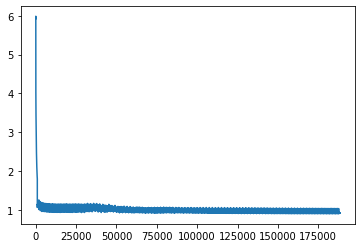

In [106]:
plt.plot(losses)